In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  
 
# Do other imports now...
import tensorflow as tf

In [2]:
# import libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
import seaborn as sns
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

datafolder = '/data/clin_notes_outcomes/prissmm_notes/'

In [3]:
# load tokenizer if already trained
with open('/homes10/klkehl/prissmm_notes_v2/notes_tokenizer_ap_find.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    

In [4]:
raw_notes = pd.read_parquet(datafolder+'parsed_82268.parquet')


In [5]:
# restrict to progress note-style documents
all_notes = raw_notes
all_notes = all_notes[all_notes.report_type.isin(["Progress Note", "PROGRESS NOTE", "CONSULT", "CONSULTATION NOTE", "VISIT NOTE", "COMPREHENSIVE H&P"])]
all_notes = all_notes[~all_notes.provider_name.isnull()]
all_notes.dfci_mrn = pd.to_numeric(all_notes.dfci_mrn)
all_notes.text = all_notes.text.str.replace('\n|\r', ' ')
all_notes.text = all_notes.text.str.lower()

all_notes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354217 entries, 0 to 6526665
Data columns (total 7 columns):
dfci_mrn         1354217 non-null int64
date             1354217 non-null datetime64[ns]
text             1354217 non-null object
source           1354217 non-null object
department       1288191 non-null object
provider_name    1354217 non-null object
report_type      1354217 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 82.7+ MB


In [6]:
# max note length = 2000 words
max_note_length=2000

In [7]:
all_notes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354217 entries, 0 to 6526665
Data columns (total 7 columns):
dfci_mrn         1354217 non-null int64
date             1354217 non-null datetime64[ns]
text             1354217 non-null object
source           1354217 non-null object
department       1288191 non-null object
provider_name    1354217 non-null object
report_type      1354217 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 82.7+ MB


In [9]:
# ML imports
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, TimeDistributed, GRU, Bidirectional, Layer
from tensorflow.keras import backend as K


In [12]:
# set up assessment and plan model


vocab_size = 10000
embedding_dims = 256
filters = 250
kernel_size = 4
lstm_dims = 129
epochs = 2
hidden_dims = 128
max_note_length=2000
batch_size = 32
from tensorflow.keras.layers import Reshape

# make model

model = Sequential()
model.add(Input(shape=(max_note_length,), dtype='float32'))
model.add(Embedding(vocab_size, embedding_dims, input_length=max_note_length, mask_zero=False))
model.add(Bidirectional(LSTM(lstm_dims, return_sequences=True)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 256)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 2000, 258)         398352    
_________________________________________________________________
time_distributed (TimeDistri (None, 2000, 1)           259       
Total params: 2,958,611
Trainable params: 2,958,611
Non-trainable params: 0
_________________________________________________________________


In [13]:
# load AP finder model weights
model.load_weights('ap_model.h5')

In [14]:
# assessment and plan words will be those words with AP model score > 0.1

def get_ap(text):
    thetext = sequence.pad_sequences(tokenizer.texts_to_sequences(text), maxlen=max_note_length)
    predictions = model.predict(thetext).squeeze(2)
    for_plot = predictions.flatten()
    import seaborn as sns
    sns.distplot(for_plot)
    ap_sequences = [np.array(text)[np.array(prediction) > 0.1] for text, prediction in zip(thetext.tolist(), predictions.tolist())]
    ap_text = tokenizer.sequences_to_texts(ap_sequences)
    return ap_text, ap_sequences

In [15]:
# remove carriage returns and make text lowercase
all_notes.text = all_notes.text.str.replace('\n|\r', ' ')
all_notes.text = all_notes.text.str.lower()
all_notes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354217 entries, 0 to 6526665
Data columns (total 7 columns):
dfci_mrn         1354217 non-null int64
date             1354217 non-null datetime64[ns]
text             1354217 non-null object
source           1354217 non-null object
department       1288191 non-null object
provider_name    1354217 non-null object
report_type      1354217 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 82.7+ MB


In [16]:
# read manually curated data

labels = pd.read_csv(datafolder + 'redcap_2g_medonc_2-1-19.csv')[['dfci_mrn','onc_visit_dt2','md_ca2','ca_status_md2']].rename(columns={'onc_visit_dt2':'encounter_date'})
labels = labels[~labels.dfci_mrn.isnull()]
labels = labels[~labels.encounter_date.isnull()]
labels['any_cancer'] = np.where(labels['md_ca2'].isin([1,11]), 1, 0)


labels = labels[~labels.any_cancer.isnull()]

labels['response'] = np.where(labels['ca_status_md2']==1, 1, 0)
labels['progression'] = np.where(labels['ca_status_md2']==4, 1, 0)
labels = labels[['dfci_mrn', 'encounter_date', 'any_cancer', 'response', 'progression']].rename(columns={'encounter_date':'date'})
labels.date = pd.to_datetime(labels.date)

labels['any_any_cancer'] = labels.groupby(['dfci_mrn','date'])['any_cancer'].transform(lambda x: 1 if any(x==1) else 0)
labels['any_response'] = labels.groupby(['dfci_mrn','date'])['response'].transform(lambda x: 1 if any(x==1) else 0)
labels['any_progression'] = labels.groupby(['dfci_mrn','date'])['progression'].transform(lambda x: 1 if any(x==1) else 0)

labels = labels.groupby(['dfci_mrn','date']).first().reset_index()[['dfci_mrn','date','any_any_cancer','any_response','any_progression']].rename(columns={'any_any_cancer':'any_cancer','any_response':'response','any_progression':'progression'})
labels.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14912 entries, 0 to 14911
Data columns (total 5 columns):
dfci_mrn       14912 non-null int64
date           14912 non-null datetime64[ns]
any_cancer     14912 non-null int64
response       14912 non-null int64
progression    14912 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 582.6 KB


In [17]:
all_notes.dfci_mrn = pd.to_numeric(all_notes.dfci_mrn)

In [18]:
# pull manually labeled data
analysis = pd.merge(all_notes, labels, on=['dfci_mrn', 'date'], how='inner')
analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13161 entries, 0 to 13160
Data columns (total 10 columns):
dfci_mrn         13161 non-null int64
date             13161 non-null datetime64[ns]
text             13161 non-null object
source           13161 non-null object
department       12692 non-null object
provider_name    13161 non-null object
report_type      13161 non-null object
any_cancer       13161 non-null int64
response         13161 non-null int64
progression      13161 non-null int64
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 1.1+ MB


In [20]:
print(len(analysis.dfci_mrn.unique()))
temp = analysis.drop_duplicates(subset=['dfci_mrn','date'])
temp.shape[0]

984


8919

921
7523


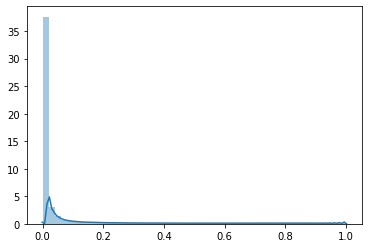

In [22]:
# for analysis, we need notes specifically from the lung medical oncologists at DFCI
# notes from other medical oncologists (common when patients had multiple primary tumors or heme disorders) and other specialists not relevant here
# kept med oncs and nps with more than 10 notes for cohort
lung_med_oncs = ['rabin,\s*mic','marcoux','awad,\s*mark','gray,\s*stacy','jackman','oxnard','kwiatkowski','gandhi,\s*leena','sinclair,\s*natalie','tahir,\s*naeem','do,\s*khanh','rossi,\s*humberto','barbie,\s*david','janne,\s*pasi','johnson,\s*bruce', 'shapiro,\s*geoff', 'lathan,\s*chris', 'kehl', 'hammerman,\s*peter','jacobson,\s*jos', 'sands,\s*jacob', 'cheng,\s*michael', 'cardarella', 'redig', 'vasconcelles', 'wong,\s*kwok', 'skarin', 'flanagan', 'rickner', 'calarese', 'mcmullin', 'power', 'silva', 'selleck', 'kulke', 'chan,\s*jennifer', 'chi,\s*dorcas', 'nayak', 'gainor', 'hilton', 'freter', 'brown,\s*jennifer', 'shields', 'kaddis', 'schlossman', 'scranton', 'sequist','azzoli','haddad,\s*robert','constantine,\s*michael','wilson,\s*fred']
new_analysis = analysis[analysis.provider_name.str.contains('|'.join(lung_med_oncs), case=False)]
new_analysis = new_analysis[new_analysis.provider_name.str.contains('M.D.|N.P.|P.A.')]

print(len(new_analysis.dfci_mrn.unique()))
temp = new_analysis.drop_duplicates(subset=['dfci_mrn','date'])
print(temp.shape[0])

missing_from_new = analysis[~analysis.dfci_mrn.isin(new_analysis.dfci_mrn)]

analysis = new_analysis
analysis['ap'], ap_sequences = get_ap(analysis.text)


In [27]:
analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7790 entries, 0 to 13160
Data columns (total 11 columns):
dfci_mrn         7790 non-null int64
date             7790 non-null datetime64[ns]
text             7790 non-null object
source           7790 non-null object
department       7499 non-null object
provider_name    7790 non-null object
report_type      7790 non-null object
any_cancer       7790 non-null int64
response         7790 non-null int64
progression      7790 non-null int64
ap               7790 non-null object
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 730.3+ KB


In [28]:
# require non-blank AP
# (some notes with oncologists' names, like extra phone call notes and clinical trial adverse event forms, legitimately did not have APs)
analysis = analysis[analysis.ap != '']
analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7599 entries, 0 to 13160
Data columns (total 11 columns):
dfci_mrn         7599 non-null int64
date             7599 non-null datetime64[ns]
text             7599 non-null object
source           7599 non-null object
department       7311 non-null object
provider_name    7599 non-null object
report_type      7599 non-null object
any_cancer       7599 non-null int64
response         7599 non-null int64
progression      7599 non-null int64
ap               7599 non-null object
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 712.4+ KB


In [29]:
# make sure only one note per oncologist per day (rarely is there more than one)
analysis = analysis.groupby(['dfci_mrn', 'date', 'text']).first().reset_index()
analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7597 entries, 0 to 7596
Data columns (total 11 columns):
dfci_mrn         7597 non-null int64
date             7597 non-null datetime64[ns]
text             7597 non-null object
source           7597 non-null object
department       7311 non-null object
provider_name    7597 non-null object
report_type      7597 non-null object
any_cancer       7597 non-null int64
response         7597 non-null int64
progression      7597 non-null int64
ap               7597 non-null object
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 653.0+ KB


In [30]:
# write dataset for classification model training
analysis.to_feather(datafolder+'ap_analysis.feather')